## Final Project Submission

Please fill out:
* Student name: Yasir F. Karim, Amir M. Edris
* Student pace: full time
* Scheduled project review date/time: 08/21/20
* Instructor name: Fang Fang Lee.

#  Scraping _The Numbers_ Website For Data
___
The Numbers is a very useful website with information on films produced worldwide. We will scrape this site for the information we need through it's report builder page. This page allows us to specify many different categories of filters such as: _Production Company, Budget, Year, Source, Genre_ etc.
   
For all our searches, we will limits our resulting view of table to only the neccessary columns. This will allow us to create one function that will extract the informantion from all the different search results through BeautifulSoup and then produce a pd.DataFrame. **As a general rule, from our conclusions from the previous notebook, we will only look at information from the past decade**.

In [1]:
import requests  # import neccessary libraries for webscraping and creating, visualizing dataframes etc.
import sys
import numpy as np
import time
import pandas as pd
import seaborn as sns
time.sleep(5)
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)  # this is to avoid viewing scientific notation

## Blumhouse Horror Movies
___
From the information gathered before, we concluded that low-budget movies have the highest **R.O.I.** Blumhouse is a production company known for making low-budget horror movies for minimal budgets. Their hits include: _Get Out, Happy Death Day, Paranormal Activity_. 

Let's analyze the data on their releases from the past 10 years and figure out what their **R.O.I.** and **profit** looks like. 
- Have they been successful in making low-budget horror movies?
- What is their ROI compared to ROI of movies in general that we have studied before?

In [3]:
# get the page URL and use request to get the content from the page as a RESPONSE type
blumhouse_url = 'https://www.the-numbers.com/movies/report/Horror/All/All/All/All/All/All/Blumhouse/All/None/None/2010/2019/None/None/None/None/None/None?show-release-date=On&view-order-by=domestic-box-office&view-order-direction=desc&show-production-budget=On&show-domestic-box-office=On&show-international-box-office=On&show-worldwide-box-office=On'
page = requests.get(blumhouse_url)
page.status_code

200

In [4]:
soup = BeautifulSoup(page.content, 'html.parser')  # use beautiful soup to be able to parse the html tags

In [5]:
tag_table = soup.find_all('table')[0]  # select the tag with the content of the resulting table
type(tag_table)  # check its type to confirm

bs4.element.Tag

In [6]:
tag_table.find_all('th')[1:]  # This is the table header row from the page or the column names that we want

[<th>Released</th>,
 <th>Title</th>,
 <th>Production<br/>Budget</th>,
 <th>Domestic<br/>Box Office</th>,
 <th>International<br/>Box Office</th>,
 <th>Worldwide<br/>Box Office</th>]

In [7]:
tag_body = tag_table.find_all('tbody')  # This tag has the all the information from the rows

print(len(tag_body))  
print(type(tag_body[0]))  # Check if it's TAG type

print(type(tag_body[0].find('tr'))) 
print(len(tag_body[0].find_all('tr')))  # the <tr> tage contains the number of rows in the table

table_rows = tag_body[0].find_all('tr')  # check to confirm the number of rows if it matches with search page

1
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
54


In [8]:
def convert_page_to_tag_with_table_rows(page):
    """ 
    This function takes in a requests.models.Response from The Numbers websites report builder page
    and returns all tags associated with rows of the resulting table from our search criteria
    """

    soup = BeautifulSoup(page.content, 'html.parser')  # Parse through the html using BeautifulSoup
    tag_table = soup.find_all('table')[0]              # Find the TAG associated with the table
    tag_body = tag_table.find_all('tbody')             # Find the TAG associated with the body of the table
    table_rows = tag_body[0].find_all('tr')            # store all the row TAGs in a list 
    
    return table_rows  # Return the list of TAGs

In [9]:
def transform_table_to_df(table_rows):
    """
    This fucntion takes in a list of TAGs associated with rows of the table resulting from The Numbers 
    websites report builder. It extracts the text from these row TAGs and transforms them into a 
    Pandas.Dataframe and returns the dataframe.
    """
    # extract the movie name, budget and the other TEXT's from the row TAGs and store them in a list
    
    titles = [table_rows[n].find('a').text for n in range(0,len(table_rows))]  
    release_dates = [table_rows[n].find_all(class_ = 'data')[1].text for n in range(0,len(table_rows))]
    budgets = [table_rows[n].find_all(class_ = 'data')[2].text for n in range(0,len(table_rows))]

    dom_incomes = [table_rows[n].find_all(class_ = 'data')[3].text for n in range(0,len(table_rows))]
    inter_income = [table_rows[n].find_all(class_ = 'data')[4].text for n in range(0,len(table_rows))]
    worldwide_gross = [table_rows[n].find_all(class_ = 'data')[5].text for n in range(0,len(table_rows))]
    
    df = pd.DataFrame({  # use the required lists to create a dataframe with the movies' information
        "movie": titles,
         "production_budget": budgets,
         "domestic_gross": dom_incomes,
         "foreign_gross": inter_income,
        "worldwide_gross": worldwide_gross
    })
    return df

In [10]:
# Use the functions created to extract the information and create the dataframe of blumhouse movies
blum_table = convert_page_to_tag_with_table_rows(page)
blumhouse_horror = transform_table_to_df(blum_table)
blumhouse_horror.head()  # check the first few rows

,movie,production_budget,domestic_gross,foreign_gross,worldwide_gross
0,Get Out,"$5,000,000","$176,040,665","$76,737,392","$252,778,057"
1,Halloween,"$10,000,000","$159,347,015","$96,143,163","$255,490,178"
2,Split,"$5,000,000","$138,141,585","$140,823,221","$278,964,806"
3,Paranormal Activity 3,"$5,000,000","$104,028,807","$103,011,037","$207,039,844"
4,Paranormal Activity 2,"$3,000,000","$84,752,907","$92,759,125","$177,512,032"


All the of columns regarding capital value seem to be `object` types. We need to convert them into `integer` type in order to explore the data and create visualizations.

Since, all the search results give us the same columns in the same format, we should create a function to complete our task and save time and space.

In [11]:
def convert_obj_to_int(df): 
    """
    This function will take in a pd.DataFrame created from our specified website and turn the object type columns
    associated with money and turn them into integer type
    """
    # Store these targeted columns into a list for iteration
    monetary_cols = ['production_budget','domestic_gross','foreign_gross','worldwide_gross']
    
    for col in monetary_cols:  # replace '$' and ',' using string method and convert to INT type
        df[col] = df[col].str.replace('$','').str.replace(',','').astype(int)
    return df  # return the dataframe with the transformed columns

convert_obj_to_int(blumhouse_horror)
blumhouse_horror.head()

,movie,production_budget,domestic_gross,foreign_gross,worldwide_gross
0,Get Out,5000000,176040665,76737392,252778057
1,Halloween,10000000,159347015,96143163,255490178
2,Split,5000000,138141585,140823221,278964806
3,Paranormal Activity 3,5000000,104028807,103011037,207039844
4,Paranormal Activity 2,3000000,84752907,92759125,177512032


In [12]:
blumhouse_horror = blumhouse_horror[:32]  # Disregard all the values with 0 domestic gross and 0 production budget

We will create another function that adds two new columns. One column regarding _Gross Profit_ calculated by `(worldwide_gross-production budget)`. The other regarding the _return on investment_ or _R.O.I_ . This is calculated by `(Profit/Budget) * 100`

In [13]:
def create_two_cols(df):
    """
    This functions takes in a dataframe and create two new columns.
    One is worldwide_gross, int type. Second is roi which is float type
    """
    df['gross_profit'] = df['worldwide_gross'] - df['production_budget']  
    df['roi'] =(df['gross_profit'] / df['production_budget']) * 100 
    
    return df

In [14]:
create_two_cols(blumhouse_horror)  # add this columns to the blumhouse dataframe
blumhouse_horror.head()

,movie,production_budget,domestic_gross,foreign_gross,worldwide_gross,gross_profit,roi
0,Get Out,5000000,176040665,76737392,252778057,247778057,4955.56
1,Halloween,10000000,159347015,96143163,255490178,245490178,2454.90
2,Split,5000000,138141585,140823221,278964806,273964806,5479.30
3,Paranormal Activity 3,5000000,104028807,103011037,207039844,202039844,4040.80
4,Paranormal Activity 2,3000000,84752907,92759125,177512032,174512032,5817.07


In [15]:
roi_blumhouse = blumhouse_horror.roi.mean()  # calculate their mean r.o.i
roi_blumhouse

3292.9243174967564

In [16]:
avg_profit_blum = blumhouse_horror.gross_profit.mean()  # calculate avg. profit
avg_budget_blum = blumhouse_horror.production_budget.mean()  # calculate avg. budget

Here is a quick visual representation of their success in Budget vs Profit metrics.

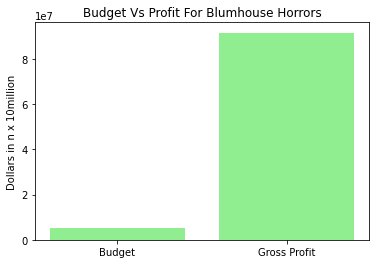

In [51]:
plt.bar(x = ['Budget','Gross Profit'], height= [avg_budget_blum,avg_profit_blum], color = 'lightgreen')
plt.ylabel('Dollars in n x 10million')
plt.title('budget vs profit for blumhouse horrors'.title())
plt.show()

### Blumhouse is  a mega success
___
In the past 10 years Blumhouse Productions have had an R.O.I of over **3200%**. From the data we gathered before, we saw the ROI of low to high budget movies ranged from approximately 150% to 300%, with low budget films being the most successful. On that scale, Blumhouse horror films blow through the roof of success. Their mean budget is about **5 million** and profit is close to **90 million**. We can try to replicate this success with Microsoft Studios, especially because they own horror game franchises such as **_State of Decay_**.

## Movies Based On Popular Intellectual Properties vs Original Films
___
- Do movies based on comic books and video games hold an advantage over original movies?

We are going to look at the data from these two categories of movies to see if there is any advantage. Microsoft has it's own gaming studio that has multiple IP's to it's name. If movies based on pre-existing IP hold an advantage than this could be used to our benefit. If not, we can go in the opposite creative direction. **First, lets get information on movies based on existing IP.**

In [18]:
# Copy and paste the url that has information on movies based on comic books from the last decade
comics_url = 'https://www.the-numbers.com/movies/report/All/All/All/All/All/Based-on-Comic-or-Graphic-Novel/All/All/All/None/None/2010/2019/None/None/None/None/None/None?show-release-date=On&view-order-by=production-budget&view-order-direction=desc&show-production-budget=On&show-domestic-box-office=On&show-international-box-office=On&show-worldwide-box-office=On'
page = requests.get(comics_url)  # convert the page to a RESPONSE type
page.status_code  # check if it is successful

200

In [19]:
# use the functions created to turn the table into a pandas dataframe
comics_table_tag = convert_page_to_tag_with_table_rows(page)
comic_book_films = transform_table_to_df(comics_table_tag)

comic_book_films.head()  # check the first 5 rows

,movie,production_budget,domestic_gross,foreign_gross,worldwide_gross
0,Avengers: Endgame,"$400,000,000","$858,373,000","$1,939,427,564","$2,797,800,564"
1,Avengers: Age of Ultron,"$365,000,000","$459,005,868","$937,093,334","$1,396,099,202"
2,Avengers: Infinity War,"$300,000,000","$678,815,482","$1,369,544,272","$2,048,359,754"
3,Justice League,"$300,000,000","$229,024,295","$426,920,914","$655,945,209"
4,Batman v Superman: Dawn of Justice,"$263,000,000","$330,360,194","$542,034,897","$872,395,091"


In [20]:
# Copy and Paste the URL containing the table of info from movies based on video games
games_url = 'https://www.the-numbers.com/movies/report/All/All/All/All/All/Based-on-Game/All/All/All/None/None/2010/2019/None/None/None/None/None/None?show-release-date=On&view-order-by=production-budget&view-order-direction=desc&show-production-budget=On&show-domestic-box-office=On&show-international-box-office=On&show-worldwide-box-office=On'
page = requests.get(games_url)  # get the RESPONSE
page.status_code  # check if it is succesful

200

In [21]:
games_table_tage = convert_page_to_tag_with_table_rows(page) # use the functions get a pandas dataframe
vdo_game_films = transform_table_to_df(games_table_tage)

vdo_game_films.head()  

,movie,production_budget,domestic_gross,foreign_gross,worldwide_gross
0,Battleship,"$220,000,000","$65,233,400","$248,244,317","$313,477,717"
1,Prince of Persia: Sands of Time,"$200,000,000","$90,759,676","$245,600,000","$336,359,676"
2,Warcraft,"$160,000,000","$47,365,290","$391,534,534","$438,899,824"
3,PokÃ©mon: Detective Pikachu,"$150,000,000","$144,105,346","$288,497,009","$432,602,355"
4,Assassinâs Creed,"$125,000,000","$54,647,948","$186,111,734","$240,759,682"


In [22]:
ip_films = pd.concat([comic_book_films, vdo_game_films])  # concatenate these dataframes vertically into a new DF
ip_films.movie.nunique()  # check if the number of movies add up to the results from both web pages

143

In [23]:
convert_obj_to_int(ip_films)  # Convert the object type columns regarding capital to int
create_two_cols(ip_films)  # add the ROI and Profit columns to the DF
ip_films.head()  # check the result

,movie,production_budget,domestic_gross,foreign_gross,worldwide_gross,gross_profit,roi
0,Avengers: Endgame,400000000,858373000,1939427564,2797800564,2397800564,599.45
1,Avengers: Age of Ultron,365000000,459005868,937093334,1396099202,1031099202,282.49
2,Avengers: Infinity War,300000000,678815482,1369544272,2048359754,1748359754,582.79
3,Justice League,300000000,229024295,426920914,655945209,355945209,118.65
4,Batman v Superman: Dawn of Justice,263000000,330360194,542034897,872395091,609395091,231.71


In [24]:
# disreagrd all the movies with no production cost and no domestic gross
ip_films = ip_films[(ip_films.production_budget > 0) & (ip_films.domestic_gross > 0)]
ip_films.shape  # check how many movies are left

(100, 7)

In [25]:
roi_ip = ip_films.roi.mean()  # calculate the mean r.o.i
roi_ip

273.77303736729334

In [26]:
avg_profit_ip = ip_films.gross_profit.mean()  # calculate the mean gross profit
avg_profit_ip

349917155.15

In [27]:
avg_budget_ip = ip_films.production_budget.mean()  # calculate the avg. budget
avg_budget_ip

125095500.0

The average budget of a film based on a comic book/video game is about `125 miliion`$. We know that budget positively correlates with gross profit from our previous analysis.

### Now, lets get information on movies based on original screenplay.
___
_The Numbers_ website limits its results to 100 rows. We divided the search through the past decade into 5 spell of 2 years each. Then, we sorted the rows according to productuon budget in order to avoid getting movies with high income first. Each of the 5 searches resulted in movies spread out evenly in their scope of budgets. The lower end of the production budgets floored at around 20 million dollars. We can considered viable since this is a low enough amount considering the size of microsoft. **In the following code we:**

- Retrieved the URL from each of the five pages.
- Converted the page to a requests.models.Response type
- Repeated the same steps as above in using the functions to create a pd.DataFrame

In [28]:
url1 = 'https://www.the-numbers.com/movies/report/All/All/All/All/All/Original-Screenplay/United-States/All/All/1/None/2010/2011/None/None/None/None/None/None?show-release-date=On&view-order-by=production-budget&view-order-direction=desc&show-production-budget=On&show-domestic-box-office=On&show-international-box-office=On&show-worldwide-box-office=On'
page = requests.get(url1)
page.status_code

200

In [29]:
og_films_table = convert_page_to_tag_with_table_rows(page)
og_films_1 = transform_table_to_df(og_films_table)
og_films_1.head()

,movie,production_budget,domestic_gross,foreign_gross,worldwide_gross
0,Toy Story 3,"$200,000,000","$415,004,880","$653,874,642","$1,068,879,522"
1,Tron: Legacy,"$200,000,000","$172,062,763","$228,000,000","$400,062,763"
2,Cars 2,"$200,000,000","$191,450,875","$368,704,508","$560,155,383"
3,Inception,"$160,000,000","$292,576,195","$542,215,766","$834,791,961"
4,Kung Fu Panda 2,"$150,000,000","$165,249,063","$499,588,484","$664,837,547"


In [30]:
url2 = 'https://www.the-numbers.com/movies/report/All/All/All/All/All/Original-Screenplay/United-States/All/All/1/None/2012/2013/None/None/None/None/None/None?show-release-date=On&view-order-by=production-budget&view-order-direction=desc&show-production-budget=On&show-domestic-box-office=On&show-international-box-office=On&show-worldwide-box-office=On'
page = requests.get(url2)
page.status_code

200

In [31]:
og_films_table = convert_page_to_tag_with_table_rows(page)
og_films_2 = transform_table_to_df(og_films_table);
og_films_2.head()

,movie,production_budget,domestic_gross,foreign_gross,worldwide_gross
0,Monsters University,"$200,000,000","$268,488,329","$475,100,000","$743,588,329"
1,Pacific Rim,"$190,000,000","$101,802,906","$309,200,000","$411,002,906"
2,Brave,"$185,000,000","$237,282,182","$317,324,350","$554,606,532"
3,47 Ronin,"$175,000,000","$38,362,475","$113,354,340","$151,716,815"
4,Wreck-It Ralph,"$165,000,000","$189,412,677","$307,098,844","$496,511,521"


In [32]:
url3 = 'https://www.the-numbers.com/movies/report/All/All/All/All/All/Original-Screenplay/United-States/All/All/1/None/2014/2015/None/None/None/None/None/None?show-release-date=On&view-order-by=production-budget&view-order-direction=desc&show-production-budget=On&show-domestic-box-office=On&show-international-box-office=On&show-worldwide-box-office=On'
page = requests.get(url3)
page.status_code

200

In [33]:
og_films_table = convert_page_to_tag_with_table_rows(page)
og_films_3 = transform_table_to_df(og_films_table);
og_films_3.head()

,movie,production_budget,domestic_gross,foreign_gross,worldwide_gross
0,Star Wars Ep. VII: The Force Awakens,"$306,000,000","$936,662,225","$1,128,815,859","$2,065,478,084"
1,Furious 7,"$190,000,000","$353,007,020","$1,165,715,774","$1,518,722,794"
2,The Good Dinosaur,"$187,500,000","$123,087,120","$210,683,917","$333,771,037"
3,Jupiter Ascending,"$179,000,000","$47,482,519","$134,500,000","$181,982,519"
4,Inside Out,"$175,000,000","$356,461,711","$498,748,492","$855,210,203"


In [34]:
url4 = 'https://www.the-numbers.com/movies/report/All/All/All/All/All/Original-Screenplay/United-States/All/All/1/None/2016/2017/None/None/None/None/None/None?show-release-date=On&view-order-by=production-budget&view-order-direction=desc&show-production-budget=On&show-domestic-box-office=On&show-international-box-office=On&show-worldwide-box-office=On'
page = requests.get(url4)
page.status_code

200

In [35]:
og_films_table = convert_page_to_tag_with_table_rows(page)
og_films_4 = transform_table_to_df(og_films_table)
og_films_4.head()

,movie,production_budget,domestic_gross,foreign_gross,worldwide_gross
0,The Fate of the Furious,"$250,000,000","$225,764,765","$1,010,939,031","$1,236,703,796"
1,Finding Dory,"$200,000,000","$486,295,561","$539,068,066","$1,025,363,627"
2,Star Wars Ep. VIII: The Last Jedi,"$200,000,000","$620,181,382","$712,358,507","$1,332,539,889"
3,Kong: Skull Island,"$185,000,000","$168,052,812","$393,019,247","$561,072,059"
4,Cars 3,"$175,000,000","$152,901,115","$230,640,254","$383,541,369"


In [36]:
url5 ='https://www.the-numbers.com/movies/report/All/All/All/All/All/Original-Screenplay/United-States/All/All/1/None/2018/2019/None/None/None/None/None/None?show-release-date=On&view-order-by=production-budget&view-order-direction=desc&show-production-budget=On&show-domestic-box-office=On&show-international-box-office=On&show-worldwide-box-office=On'
page = requests.get(url5)
page.status_code

200

In [37]:
og_films_table = convert_page_to_tag_with_table_rows(page)
og_films_5 = transform_table_to_df(og_films_table)
og_films_5.head()

,movie,production_budget,domestic_gross,foreign_gross,worldwide_gross
0,Star Wars: The Rise of Skywalker,"$275,000,000","$515,202,542","$557,741,680","$1,072,944,222"
1,Incredibles 2,"$200,000,000","$608,581,744","$634,223,615","$1,242,805,359"
2,Toy Story 4,"$200,000,000","$434,038,008","$639,356,805","$1,073,394,813"
3,Maleficent: Mistress of Evil,"$185,000,000","$113,929,605","$375,416,890","$489,346,495"
4,Terminator: Dark Fate,"$185,000,000","$62,253,077","$188,119,290","$250,372,367"


We have now collected all the information we set out to collect on original sourced movies into five dataframes. We can now **concatenate** these dataframe into on new dataframe.

In [38]:
# use pd.concat to create 1 new DF consisting the previous 5
original_films = pd.concat([og_films_1, og_films_2, og_films_3, og_films_4, og_films_5])

In [39]:
original_films.movie.nunique()  # check if they have 500 unique film names

500

In [40]:
convert_obj_to_int(original_films)  # Convert the object type columns regarding capital to int
create_two_cols(original_films); # add the ROI and Profit columns to the DF

In [41]:
original_films.head()  # check the first 20 rows of the new dataframe.

,movie,production_budget,domestic_gross,foreign_gross,worldwide_gross,gross_profit,roi
0,Toy Story 3,200000000,415004880,653874642,1068879522,868879522,434.44
1,Tron: Legacy,200000000,172062763,228000000,400062763,200062763,100.03
2,Cars 2,200000000,191450875,368704508,560155383,360155383,180.08
3,Inception,160000000,292576195,542215766,834791961,674791961,421.74
4,Kung Fu Panda 2,150000000,165249063,499588484,664837547,514837547,343.23


In [42]:
# remove films with no domestic gross and production as we have throught this project
original_films = original_films[(original_films.domestic_gross > 0) & (original_films.production_budget > 0)]
original_films.movie.nunique()  # check how many movies were deleted

481

### Original but filled with sequels?
Each time we looked at the first 5 rows of the 5 different dataset, we saw that in most cases there were sequels of popular franchises present. These movies, although considered to be based on original screenplay, are continuations of very popular and beloved movies. Some these movies might be considered as well-known I.P's. Next, we want to check if the highest grossing movies of this original films list is dominated by sequels or remakes.

In [43]:
original_films.sort_values(by= 'gross_profit', ascending= False).head(20)

,movie,production_budget,domestic_gross,foreign_gross,worldwide_gross,gross_profit,roi
0,Star Wars Ep. VII: The Force Awakens,306000000,936662225,1128815859,2065478084,1759478084,574.99
1,Furious 7,190000000,353007020,1165715774,1518722794,1328722794,699.33
7,Frozen II,150000000,477373578,970176133,1447549711,1297549711,865.03
2,Star Wars Ep. VIII: The Last Jedi,200000000,620181382,712358507,1332539889,1132539889,566.27
1,Incredibles 2,200000000,608581744,634223615,1242805359,1042805359,521.40
0,The Fate of the Furious,250000000,225764765,1010939031,1236703796,986703796,394.68
26,Despicable Me 3,75000000,264624300,770063549,1034687849,959687849,1279.58
22,Despicable Me 2,76000000,368065385,607151450,975216835,899216835,1183.18
2,Toy Story 4,200000000,434038008,639356805,1073394813,873394813,436.70
22,Jumanji: Welcome to the Jungle,90000000,404508916,556721277,961230193,871230193,968.03


As we suspected, when sorted by gross profit the top 10 movies are **all sequels**. These films are definitely skewing the ROI and gross profit of original movies towards the higher end. 

Microsoft, as a new movie studio, is going to be making wholly original films that cannot churn out sequels instantly. Therefore, we cannot disregard sequels from the list but we should keep their influce in the back of our mind as we continue our analysis.

In [44]:
avg_profit_og = original_films.gross_profit.mean()  # calculate avg. gross profit
avg_profit_og

126711112.11018711

In [45]:
roi_og = original_films.roi.mean()  # calculate avg roi
roi_og

226.7664750582466

In [46]:
avg_budget_og = original_films.production_budget.mean()  # calculate avg. budget
avg_budget_og

55928066.52806653

The average budget of a film based on original screenplay is about `55 million`. Therefore, the ratio of budget between original and non-original movies are approximately `1 : 2.28`

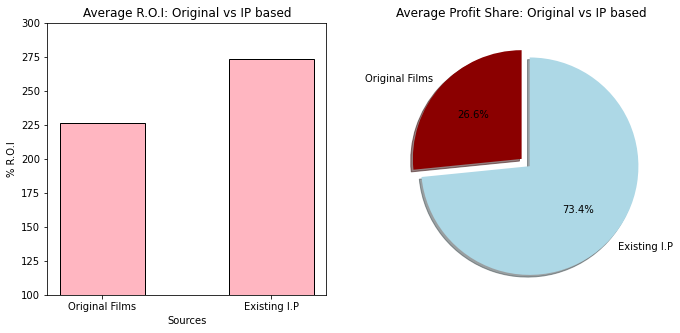

In [63]:
fig = plt.figure(figsize = (11,5))  # create a figure
ax1 = fig.add_subplot(1,2,1)  # add subplots with 1 row and 2 columns
ax2 = fig.add_subplot(1,2,2)

ax1.bar(height = [roi_og, roi_ip] , x = ['Original Films', 'Existing I.P'], width = 0.5, color ='lightpink',
       edgecolor = 'black')
ax1.set_ylim(100,300)
ax2.pie([avg_profit_og, avg_profit_ip], labels =['Original Films','Existing I.P'],shadow = True, startangle = 90,
       explode = (0 ,0.1), autopct='%1.1f%%', colors = ['darkred', 'lightblue'])

ax1.set_title('Average R.O.I: Original vs IP based')
ax1.set_xlabel('Sources')
ax1.set_ylabel('% R.O.I')
ax2.set_title('Average Profit Share: Original vs IP based')
plt.show()

### Conclusion: Original vs IP
From the above analysis, we can make the following conclusions:

- Movies based on IP, on a higher budget, yeild far higher profits compared to original movies.
- Furthermore, even with the help sequels that dominate year-end box office charts original films have an ROI of almost `50%` less.

Therefore, we can conclude that Microsoft should use it extensive library of popular video games as source material for films. Popular games such as Halo, Minecraft and Forza all belonging to the action adventure genre, which can be funded by big budget for adaptation into movies. They can help launch this studio with success. If so, these projects lend themselves to possible sequels like their video game versions. Sequels, as we have seen are massively profitable and will further boost the viability of the studio.